In [131]:
!pip install scikit-learn
!pip install nltk
!pip install contractions
!pip install textblob
!pip install wordcloud

In [132]:
# Standard Libraries
import os
import re
import string

# External Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
import contractions

# Set up seaborn for enhanced visualization
sns.set()

In [133]:
file_id = '1opR4LaszvBIPP6rUOeNKxzYu7HSYCvpa'
url = f'https://drive.google.com/uc?id={file_id}'
output_path = '/content/Sarcasm_Headlines_Dataset.json'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)
else:
    print(f"The file '{output_path}' already exists.")

The file '/content/Sarcasm_Headlines_Dataset.json' already exists.


In [134]:
file_id = '1GrHdDqWA8J4Xgx0kMcVg0B_U-ukrbBSl'
url = f'https://drive.google.com/uc?id={file_id}'
output_path2 = '/content/Sarcasm_Headlines_Dataset_v2.json'
if not os.path.exists(output_path2):
    gdown.download(url, output_path2, quiet=False)
else:
    print(f"The file '{output_path2}' already exists.")

The file '/content/Sarcasm_Headlines_Dataset_v2.json' already exists.


In [135]:
df1 = pd.read_json(output_path, lines=True)
df1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [136]:
df2 = pd.read_json(output_path2, lines=True)
df2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [137]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [138]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [139]:
df = pd.concat([df1, df2], axis=0)
df = df.reindex(columns=['is_sarcastic', 'headline', 'article_link'])
df.head()

,is_sarcastic,headline,article_link
0,0,former versace store clerk sues over secret 'b...,https://www.huffingtonpost.com/entry/versace-b...
1,0,the 'roseanne' revival catches up to our thorn...,https://www.huffingtonpost.com/entry/roseanne-...
2,1,mom starting to fear son's web series closest ...,https://local.theonion.com/mom-starting-to-fea...
3,1,"boehner just wants wife to listen, not come up...",https://politics.theonion.com/boehner-just-wan...
4,0,j.k. rowling wishes snape happy birthday in th...,https://www.huffingtonpost.com/entry/jk-rowlin...


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  55328 non-null  int64 
 1   headline      55328 non-null  object
 2   article_link  55328 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


## Visualisasi

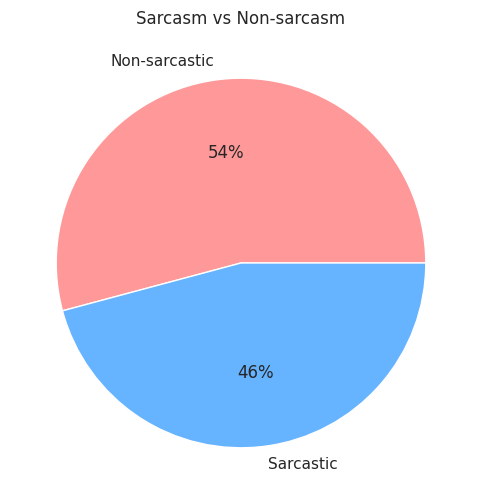

In [141]:
plt.figure(figsize=(8, 6))
# pie plot
plt.pie(df['is_sarcastic'].value_counts(), labels=['Non-sarcastic', 'Sarcastic'], autopct='%1.0f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Sarcasm vs Non-sarcasm')
plt.show()

Looks great! classification is pretty balanced, so we don't need to worry about that. Let's take a look at the data.

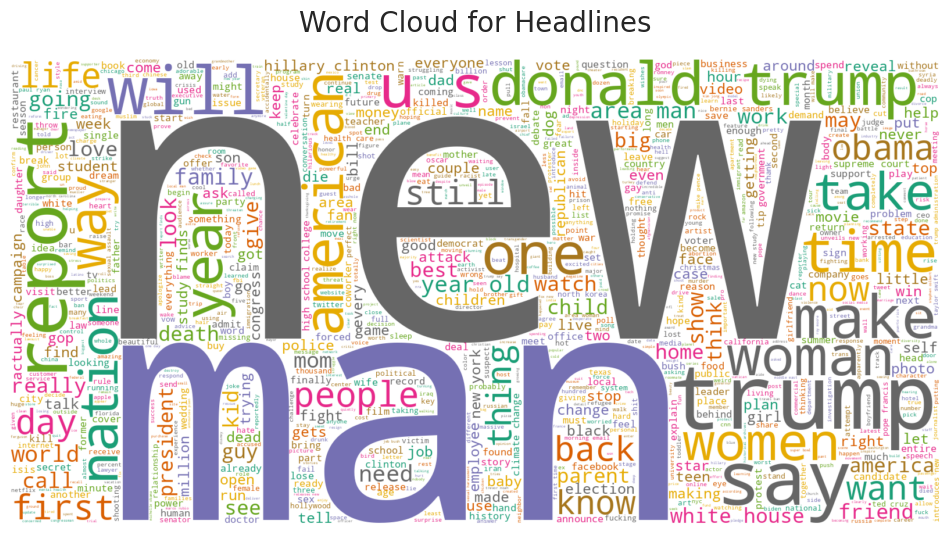

In [142]:
# Set a nice color palette
color_map = 'Dark2'

# Create a figure and set its size
plt.figure(figsize=(12, 8))

# Generate the word cloud
wc = WordCloud(
    max_words=1000,
    width=1600,
    height=800,
    background_color='white',  # Background color
    colormap=color_map,        # Color scheme
    contour_color='black',     # Contour color
).generate(" ".join(df['headline']))

# Display the word cloud with interpolation for smoother edges
plt.imshow(wc, interpolation='bilinear')

# Turn off axis
plt.axis('off')

# Add a title
plt.title('Word Cloud for Headlines', fontsize=20, pad=20)

# Show the plot
plt.show()


## Feature Engineering

In [143]:
## Subjectivity score
df['subjectivity'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,is_sarcastic,headline,article_link,subjectivity
0,0,former versace store clerk sues over secret 'b...,https://www.huffingtonpost.com/entry/versace-b...,0.377778
1,0,the 'roseanne' revival catches up to our thorn...,https://www.huffingtonpost.com/entry/roseanne-...,0.400000
2,1,mom starting to fear son's web series closest ...,https://local.theonion.com/mom-starting-to-fea...,0.100000
3,1,"boehner just wants wife to listen, not come up...",https://politics.theonion.com/boehner-just-wan...,0.100000
4,0,j.k. rowling wishes snape happy birthday in th...,https://www.huffingtonpost.com/entry/jk-rowlin...,0.833333


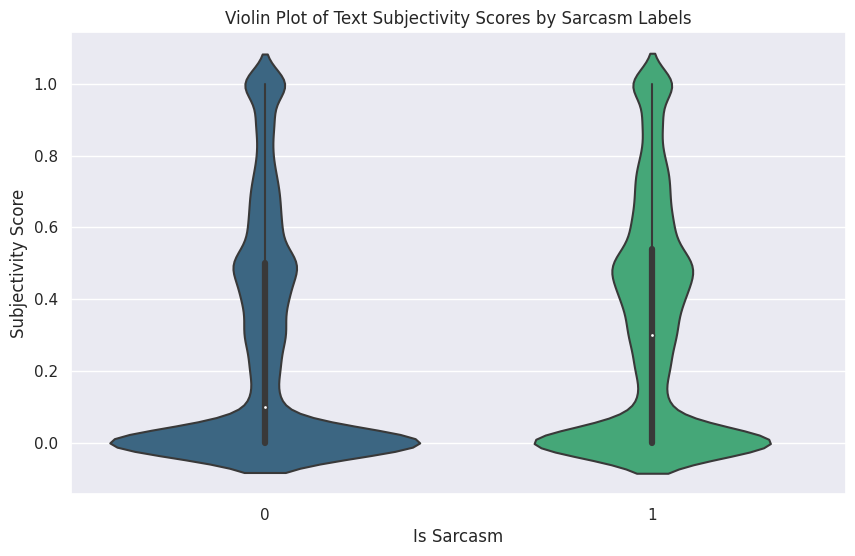

In [144]:
# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_sarcastic', y='subjectivity', data=df, palette='viridis')

# Set labels and title
plt.title('Violin Plot of Text Subjectivity Scores by Sarcasm Labels')
plt.xlabel('Is Sarcasm')
plt.ylabel('Subjectivity Score')

# Show the plot
plt.show()


## Preprocessing

In [145]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
subjectivity    0
dtype: int64

In [146]:
df.drop('article_link', axis=1, inplace=True)

In [147]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n'

def preprocess_text(text):
   # Convert to lowercase
   text = text.lower()

   # Expand contractions
   text = contractions.fix(text)

   # Remove special characters and symbols
   text = re.sub(r"[^a-zA-Z0-9]", " ", text)

   # Tokenization
   tokens = word_tokenize(text)

   # Remove stop words
   stop_words = set(stopwords.words('english'))
   tokens = [token for token in tokens if token not in stop_words]

   # Lemmatization (using WordNet Lemmatizer)
   lemmatizer = WordNetLemmatizer()
   tokens = [lemmatizer.lemmatize(token, pos=penn2morphy(tag)) for token, tag in pos_tag(tokens)]

   # Rejoin tokens into a single string
   preprocessed_text = ' '.join(tokens)

   return preprocessed_text

# Apply preprocessing to the 'headline' column
df['processed_headline'] = df['headline'].apply(lambda x: preprocess_text(x))

# Display the DataFrame with the processed headline column
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,is_sarcastic,headline,subjectivity,processed_headline
0,0,former versace store clerk sues over secret 'b...,0.377778,former versace store clerk sue secret black co...
1,0,the 'roseanne' revival catches up to our thorn...,0.400000,roseanne revival catch thorny political mood w...
2,1,mom starting to fear son's web series closest ...,0.100000,mom start fear son web series closest thing gr...
3,1,"boehner just wants wife to listen, not come up...",0.100000,boehner want wife listen come alternative debt...
4,0,j.k. rowling wishes snape happy birthday in th...,0.833333,j k rowling wish snape happy birthday magical way


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_sarcastic        55328 non-null  int64  
 1   headline            55328 non-null  object 
 2   subjectivity        55328 non-null  float64
 3   processed_headline  55328 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.1+ MB


In [149]:
all_words = df['processed_headline'].str.split().tolist()
unique_words = [list(set(words)) for words in all_words]
# Flatten the list of lists into a single list
flat_list = [word for sublist in unique_words for word in sublist]

# Count the number of unique words
unique_word_count = len(set(flat_list))
print(flat_list[:10], unique_word_count)

['sue', 'shopper', 'former', 'store', 'black', 'clerk', 'minority', 'versace', 'code', 'secret'] 21212


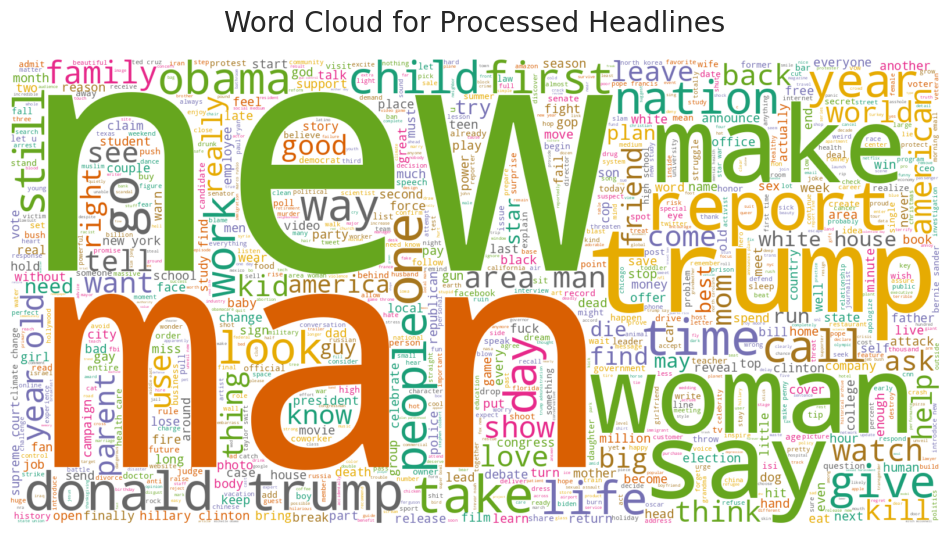

In [150]:
# Set a nice color palette
color_map = 'Dark2'

# Create a figure and set its size
plt.figure(figsize=(12, 8))

# Generate the word cloud
wc = WordCloud(
    max_words=1000,
    width=1600,
    height=800,
    background_color='white',  # Background color
    colormap=color_map,        # Color scheme
    contour_color='black',     # Contour color
).generate(" ".join(df['processed_headline']))

# Display the word cloud with interpolation for smoother edges
plt.imshow(wc, interpolation='bilinear')

# Turn off axis
plt.axis('off')

# Add a title
plt.title('Word Cloud for Processed Headlines', fontsize=20, pad=20)

# Show the plot
plt.show()


## Feature Extraction

In [151]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=32768, ngram_range=(1, 4), tokenizer=nltk.word_tokenize)
X = vectorizer.fit_transform(df['processed_headline'])
y = df['is_sarcastic']
print(X[:10])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  (0, 28126)	0.4160108823255676
  (0, 26852)	0.3643329984527987
  (0, 16363)	0.33418744548560897
  (0, 5143)	0.3273662447026033
  (0, 3191)	0.22586488253749362
  (0, 26350)	0.259496678591912
  (0, 28399)	0.29807910525143455
  (0, 4977)	0.34650773624714154
  (0, 28125)	0.27988371280565766
  (0, 9708)	0.2640821402704285
  (1, 32413)	0.37814732963116715
  (1, 31778)	0.25848544230180076
  (1, 16623)	0.36240495135441175
  (1, 22637)	0.2862490170472802
  (1, 29375)	0.42262611857872706
  (1, 4332)	0.293063460636767
  (1, 25311)	0.37222590561776653
  (1, 25642)	0.416968670053096
  (2, 31687)	0.3532350392087632
  (2, 16538)	0.3953568518230055
  (2, 10961)	0.36179056962789646
  (2, 29253)	0.20433331626205892
  (2, 5081)	0.3824561946511874
  (2, 26579)	0.27103285797870375
  (2, 31685)	0.3156291372649445
  :	:
  (7, 32298)	0.21795204112951547
  (7, 26131)	0.22068143941521243
  (7, 13631)	0.22631435825529816
  (7, 26522)	0.26596915908472163
  (7, 4442)	0.2672084922475068
  (8, 12214)	0.460634380901

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (44262, 32768)
X_test shape: (11066, 32768)
y_train shape: (44262,)
y_test shape: (11066,)


In [153]:
# Define the parameter grid
# param_dist = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }

# Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=LogisticRegression(),
#     param_distributions=param_dist,
#     n_iter=10,  # Number of random combinations to try
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# Fit the RandomizedSearchCV object to the data
# random_search.fit(X_train, y_train)

# Print the best parameters
# print(random_search.best_params_)

# Set the model with the best parameters
# model = random_search.best_estimator_


In [154]:
model = LogisticRegression(solver='saga', penalty='l2', C=100)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=100, solver='saga')

In [155]:
y_pred = model.predict(X_test)
print(y_pred[:10])

[0 0 1 0 0 1 0 0 1 1]


## Evaluate

In [156]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)

# Print the cross-validated scores
print("Cross-validated Scores:", cv_scores)

# Print the mean and standard deviation of the cross-validated scores
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-validated Scores: [0.99566239 0.99557202 0.94659317 0.97984636 0.98084049]
Mean CV Score: 0.9797
Standard Deviation of CV Scores: 0.0179


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [157]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[5798,  210],
       [ 299, 4759]])

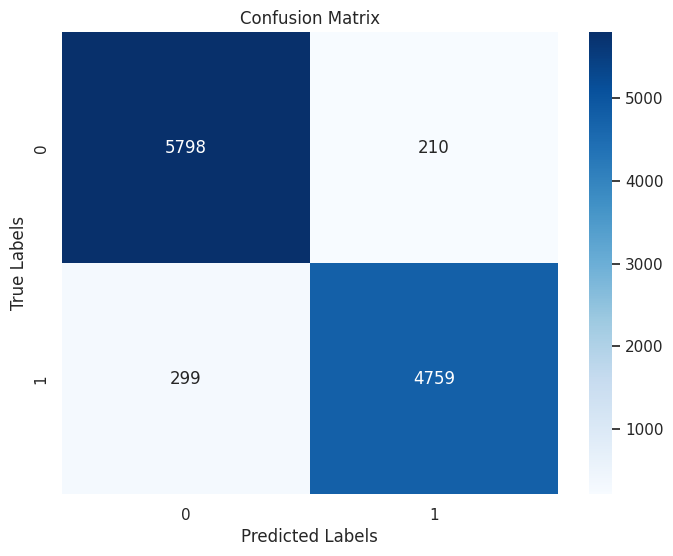

In [158]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [159]:
# evaluate
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6008
           1       0.96      0.94      0.95      5058

    accuracy                           0.95     11066
   macro avg       0.95      0.95      0.95     11066
weighted avg       0.95      0.95      0.95     11066

0.9540032532080246


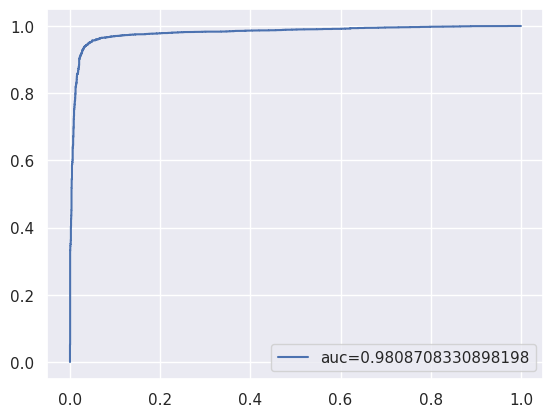

AUC: 0.9808708330898198


In [160]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[::, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', auc)

In [161]:
# Create predict one function
def predict_one(text):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Vectorize the preprocessed text
    vectorized_text = vectorizer.transform([preprocessed_text])

    # Make a prediction
    prediction = model.predict(vectorized_text)

    # Return the prediction
    return prediction[0]
# test predict one function


In [162]:
# Test the predict_one function with an example text
example_text = "New Study Reveals That Sleeping Eight Hours a Day Makes You Well-Rested"
prediction_result = predict_one(example_text)

# Print the result
print(f'Text: {example_text}')
print(f'Prediction: {prediction_result}')

Text: New Study Reveals That Sleeping Eight Hours a Day Makes You Well-Rested
Prediction: 1


In [163]:
# Test the predict_one function with an example text
example_text = "Health Officials Launch Campaign to Promote Vaccination Awareness"
prediction_result = predict_one(example_text)

# Print the result
print(f'Text: {example_text}')
print(f'Prediction: {prediction_result}')

Text: Health Officials Launch Campaign to Promote Vaccination Awareness
Prediction: 0
